In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('../Downloads/all_month (1).csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
import matplotlib.pyplot as plt
from sklearn import preprocessing;
from sklearn import model_selection;
from sklearn import linear_model;
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
import xgboost as xgb

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Clean up the data by first extracting only date from 'time' column by considering string[ : 10]. hence we can get desired date

In [4]:
df = pd.read_csv('../Downloads/all_month (1).csv')


In [5]:
df = df.sort_values('time', ascending=True)

#Date extraction
df['date'] = df['time'].str[0:10]
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,date
10835,2024-04-23T12:14:31.460Z,59.993000,-153.104333,5.87,-0.91,ml,4.0,103.0,0.02156,0.10,...,"60 km ENE of Pedro Bay, Alaska",earthquake,0.73,1.170,0.264393,4.0,reviewed,av,av,2024-04-23
10834,2024-04-23T12:18:38.840Z,36.116333,-117.880167,8.03,0.82,ml,20.0,91.0,0.02053,0.13,...,"10 km NE of Coso Junction, CA",earthquake,0.22,0.420,0.301000,10.0,reviewed,ci,ci,2024-04-23
10833,2024-04-23T12:20:49.020Z,34.036833,-117.246333,16.30,0.83,ml,35.0,81.0,0.09249,0.14,...,"2 km SE of Loma Linda, CA",earthquake,0.20,0.450,0.075000,11.0,reviewed,ci,ci,2024-04-23
10832,2024-04-23T12:24:58.623Z,83.503900,114.676600,10.00,4.40,mb,86.0,49.0,12.24200,0.52,...,north of Severnaya Zemlya,earthquake,6.41,1.904,0.062000,78.0,reviewed,us,us,2024-04-23
10831,2024-04-23T12:25:47.001Z,-16.156400,-74.364200,35.00,4.10,mb,17.0,147.0,4.42900,0.81,...,"39 km S of Atiquipa, Peru",earthquake,10.58,1.970,0.184000,8.0,reviewed,us,us,2024-04-23


In [6]:
df = df[['date', 'latitude', 'longitude', 'depth', 'mag', 'place','nst']]
# df['date'] = df['time'].str.split(', ', expand=True) 
newdf = df['place'].str.split(', ', expand=True) 

In [7]:
df = df[['date', 'latitude', 'longitude', 'depth', 'mag', 'place','nst']]

In [8]:
print('total locations:',len(set(df['place'])))

total locations: 5006


In [9]:
df.isnull().sum()
df.dropna

<bound method DataFrame.dropna of              date   latitude   longitude      depth   mag  \
10835  2024-04-23  59.993000 -153.104333   5.870000 -0.91   
10834  2024-04-23  36.116333 -117.880167   8.030000  0.82   
10833  2024-04-23  34.036833 -117.246333  16.300000  0.83   
10832  2024-04-23  83.503900  114.676600  10.000000  4.40   
10831  2024-04-23 -16.156400  -74.364200  35.000000  4.10   
...           ...        ...         ...        ...   ...   
4      2024-05-23  38.832832 -122.878830   1.920000  0.69   
3      2024-05-23  33.586167 -116.808167   7.650000  0.23   
2      2024-05-23 -37.151400   47.693600  10.000000  5.60   
1      2024-05-23  19.224333 -155.404159  32.799999  1.94   
0      2024-05-23  64.412800 -146.752100   6.300000  0.90   

                                         place   nst  
10835           60 km ENE of Pedro Bay, Alaska   4.0  
10834            10 km NE of Coso Junction, CA  20.0  
10833                2 km SE of Loma Linda, CA  35.0  
10832        

Bar plot of mean magnitude vs place, as we can see from the graph, only few countries are considered as epicenter or dangerous since they have magnitude more than 2.8 (I have considered here)

In [10]:
df.describe()

,latitude,longitude,depth,mag,nst
count,10836.000000,10836.000000,10836.000000,10836.000000,9288.000000
mean,37.537273,-115.895347,18.495123,1.519496,22.898794
std,19.376296,64.123904,48.693183,1.248014,21.620230
min,-62.219900,-179.977200,-2.980000,-1.590000,0.000000
25%,32.301250,-152.429625,2.120000,0.770000,10.000000
50%,38.793667,-122.790917,6.522800,1.355000,17.000000
75%,51.959850,-115.538333,12.300000,1.910000,28.000000
max,85.247900,179.983300,628.645000,6.500000,313.000000


In [11]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('../Downloads/all_month (1).csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Lets consider 3 as threshold for how high the earthquake has hit and lets visualise countries with more than 3 magnitude.


In [12]:
# calculate mean latitude and longitude for simplified locations

df_coords = df[['place', 'latitude', 'longitude']]
df_coords = df_coords.groupby(['place'], as_index=False).mean()
df_coords = df_coords[['place', 'latitude', 'longitude']]

In [13]:
df = df[['date', 'depth', 'mag', 'place','nst']]
df = pd.merge(left=df, right=df_coords, how='inner', on=['place'])

print('total locations:',len(set(df['place'])))

total locations: 5006


Feature Engineering and Data wrangling
Set rolling window size for future prediction based on past values with fixed window size in past
We have created 6 new features based on rolling window size on average depth and average magnitude.
A final outcome 'mag_outcome' has been defined as target values and the output is considered as shifted values from set rolling window of past days eg: '7'.

In [14]:
eq_tmp = df.copy()

DAYS_OUT_TO_PREDICT = 7
eq_data = []
eq_data_last_days_out = []

for place in list(set(eq_tmp['place'])):
    temp_df = eq_tmp[eq_tmp['place'] == place].copy()
    for window in [7, 15, 22]:
        temp_df['depth_ewma_22'] = temp_df['depth'].ewm(span=22, min_periods=1, adjust=False).mean()
        temp_df['depth_ewma_15'] = temp_df['depth'].ewm(span=15, min_periods=1, adjust=False).mean()
        temp_df['depth_ewma_7'] = temp_df['depth'].ewm(span=7, min_periods=1, adjust=False).mean()
        temp_df['mag_ewma_22'] = temp_df['mag'].ewm(span=22, min_periods=1, adjust=False).mean()
        temp_df['mag_ewma_15'] = temp_df['mag'].ewm(span=15, min_periods=1, adjust=False).mean()
        temp_df['mag_ewma_7'] = temp_df['mag'].ewm(span=7, min_periods=1, adjust=False).mean()
        temp_df[f'tremors_count_{window}d'] = temp_df['mag'].rolling(window=window, min_periods=1).count()
        temp_df['energy'] = 10 ** (1.5 * temp_df['mag'] + 11.8)
        temp_df[f'total_energy_{window}d'] = temp_df['energy'].rolling(window=window, min_periods=1).sum()

    temp_df['mag_outcome'] = temp_df['mag_ewma_7'].shift(-DAYS_OUT_TO_PREDICT)
    
    eq_data_last_days_out.append(temp_df.tail(DAYS_OUT_TO_PREDICT))
    eq_data.append(temp_df)

In [15]:
# concat all location-based dataframes into master dataframe
eq_all = pd.concat(eq_data)

In [16]:
# remove any NaN fields
eq_all = eq_all[np.isfinite(eq_all['depth_ewma_22'])]
eq_all = eq_all[np.isfinite(eq_all['mag_ewma_22'])]
eq_all = eq_all[np.isfinite(eq_all['mag_outcome'])]

In [17]:
# keep our live data for predictions
eq_data_last_days_out = pd.concat(eq_data_last_days_out)


eq_data_last_days_out = eq_data_last_days_out[np.isfinite(eq_data_last_days_out['mag_ewma_22'])]
predict_unknown=eq_data_last_days_out

In [18]:
# considered magnitude above 2.5 as dangerous hence prediction outcome as '1' elso '0'.
eq_all['mag_outcome'] = np.where(eq_all['mag_outcome'] > 2.5, 1,0)
print(eq_all['mag_outcome'].describe())
eq_all['mag_outcome'].value_counts()

count    3160.000000
mean        0.040823
std         0.197911
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: mag_outcome, dtype: float64


0    3031
1     129
Name: mag_outcome, dtype: int64

Save the data of of fixed rolling window and live unknown prediction data in sql database using sql engine

In [19]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///Earthquakedata.db')
eq_all.to_sql('Earthquake_features', engine, index=False,if_exists='replace')

In [20]:
engine = create_engine('sqlite:///Earthquakedata_predict.db')
predict_unknown.to_sql('Earthquake_predict', engine, index=False,if_exists='replace')

In [21]:
engine =create_engine('sqlite:///Earthquakedata.db')
df_features = pd.read_sql_table('Earthquake_features',con=engine)

In [22]:
engine =create_engine('sqlite:///Earthquakedata_predict.db')
df_predict = pd.read_sql_table('Earthquake_predict',con=engine)

Training is done by considering 22, 15, 7 days window past features rolling average and outcome data is shifted to next 7 days as prediction.

In [23]:
df_predict.columns

Index(['date', 'depth', 'mag', 'place', 'nst', 'latitude', 'longitude',
       'depth_ewma_22', 'depth_ewma_15', 'depth_ewma_7', 'mag_ewma_22',
       'mag_ewma_15', 'mag_ewma_7', 'tremors_count_7d', 'energy',
       'total_energy_7d', 'tremors_count_15d', 'total_energy_15d',
       'tremors_count_22d', 'total_energy_22d', 'mag_outcome'],
      dtype='object')

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
features = [f for f in list(df_features) if f not in ['date', 'lon_box_mean',
 'lat_box_mean', 'mag_outcome', 'mag', 'place',
 'combo_box_mean',  'latitude',
 'longitude']]
X_train, X_test, y_train, y_test = train_test_split(df_features[features],
                     df_features['mag_outcome'], test_size=0.3, random_state=42)

**Training phase**

In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

**XGBoost**

F:\Anaconda\lib\site-packages\xgboost\core.py:160: UserWarning: [16:16:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


0.9994076330709994
AUC: 0.9994


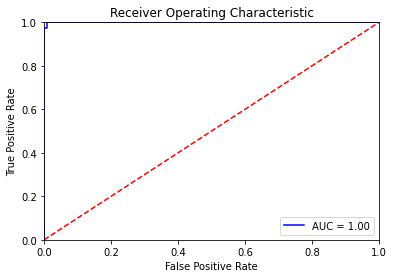

In [28]:
from sklearn.metrics import roc_curve, auc

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

param = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'max_depth': 6, 
        'silent': 1} 
num_round = 5000   
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)

print (roc_auc_score(y_test, preds))
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))  

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()




**PREDICTION**

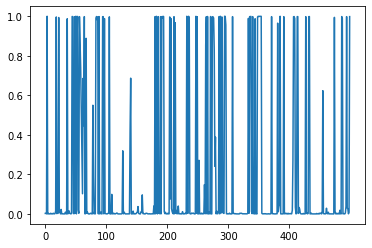

In [48]:
dlive = xgb.DMatrix(df_predict[features]) #, label=[])
preds = bst.predict(dlive)

plt.plot(range(500), preds[:500])
plt.xticks(range(0, 500, 100))  # Set ticks every 100 values
plt.show()


In [30]:
live_set = df_predict[['date', 'place', 'latitude', 'longitude','nst']]
live_set.loc[:,'quake'] = preds
# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='d')

live_set.tail()

F:\Anaconda\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,date,place,latitude,longitude,nst,quake
6784,2024-05-30,"8 km WNW of Harding-Birch Lakes, Alaska",64.412800,-146.752100,NaN,0.000150
6785,2024-05-30,"9 km N of Banning, CA",34.004167,-116.866667,53.0,0.000342
6786,2024-05-30,Carlsberg Ridge,5.442900,61.685700,82.0,0.998197
6787,2024-05-30,South Sandwich Islands region,-56.404507,-26.873077,41.0,0.993252
6788,2024-05-30,Southwest Indian Ridge,-37.151400,47.693600,73.0,0.998197


In [31]:
import datetime as dt
# convert date to proper format for prediction

days = list(set([d for d in live_set['date'].astype(str) if d > (dt.datetime.today() - dt.timedelta(days=2)).strftime('%Y-%m-%d')]))
days


['2024-05-29',
 '2024-05-24',
 '2024-05-30',
 '2024-05-28',
 '2024-05-25',
 '2024-05-26',
 '2024-05-27']

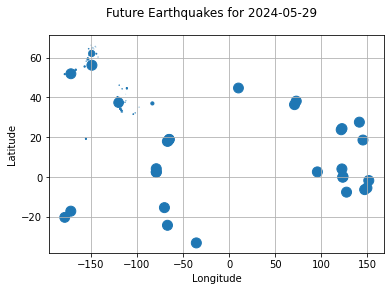

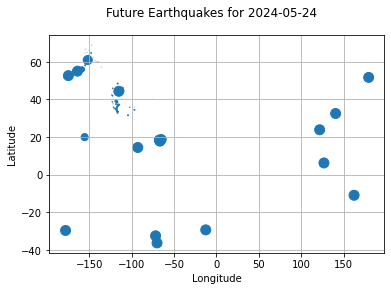

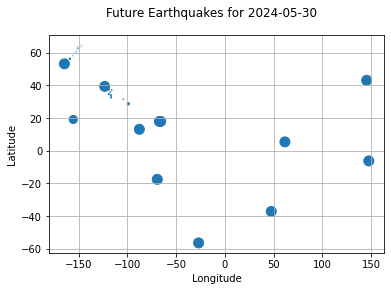

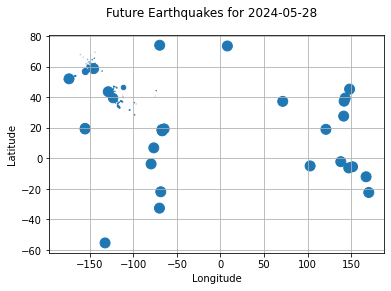

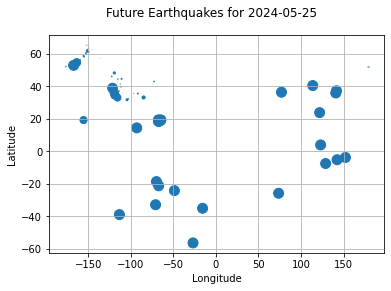

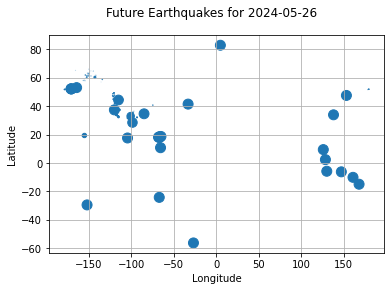

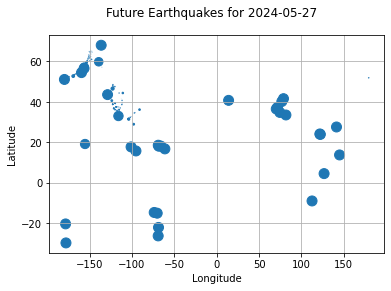

In [32]:
# place, date, lat and long with earthquake probability for next 7 days
for i in range(0,7):
    live_set_tmp = live_set[live_set['date'] == days[i]]
    plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
    plt.suptitle('Future Earthquakes for ' + days[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.show()

In [33]:
for i in range(min(7, len(days))):
    live_set_tmp = live_set[live_set['date'] == days[i]]
    print(f"Future Earthquakes for {days[i]}:")
    for index, row in live_set_tmp.iterrows():
        print(f"Location: {row['latitude']}, {row['longitude']}, Magnitude: {row['quake']} , Place:{row['place']}")


Future Earthquakes for 2024-05-29:
Location: 38.78066635, -122.7551651, Magnitude: 0.00721502210944891 , Place:0 km NNE of The Geysers, CA
Location: 38.78183330428572, -122.74411845714285, Magnitude: 4.06864273827523e-05 , Place:1 km ENE of The Geysers, CA
Location: 40.228083334999994, -121.17816665000001, Magnitude: 0.008458894677460194 , Place:1 km N of Almanor, CA
Location: 40.214, -121.17, Magnitude: 0.00686375517398119 , Place:1 km SE of Almanor, CA
Location: 38.862, -119.6589, Magnitude: 0.003529086709022522 , Place:1 km W of Carter Springs, Nevada
Location: 19.2010417125, -155.379581675, Magnitude: 1.7491179278295022e-06 , Place:10 km E of Pāhala, Hawaii
Location: 19.29283333, -155.44816665, Magnitude: 0.013203244656324387 , Place:10 km NNE of Pāhala, Hawaii
Location: 39.3927, -119.703, Magnitude: 0.0017554163932800293 , Place:10 km NNW of Virginia City, Nevada
Location: 38.834041745, -122.84381869318182, Magnitude: 3.055966226384044e-05 , Place:10 km NW of The Geysers, CA
Locat

In [34]:
bst.save_model('xgboost_model.model')

xgboost_model = xgb.Booster() 
xgboost_model.load_model('xgboost_model.model')

F:\Anaconda\lib\site-packages\xgboost\core.py:160: UserWarning: [16:17:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [35]:
df.dropna(inplace=True)
X = df[['latitude', 'longitude', 'depth', 'nst']]
y = df['mag']
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [36]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
scores= {"Model name": ["Random Forest"], "mse": [], "R^2": []}


y_pred = rf.predict(X_test)

# Evaluate the performance of the model using mean squared error and R^2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

scores['mse'].append(mse)
scores['R^2'].append(r2)

print('Mean Squared Error: ', mse)
print('R^2 Score: ', r2)

Mean Squared Error:  0.12512175239254064
R^2 Score:  0.9320419802370846


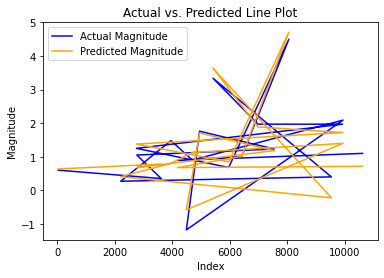

In [38]:
plt.plot(y_test.index[:20], y_test[:20], color='blue', label='Actual Magnitude')
plt.plot(y_test.index[:20], y_pred[:20], color='orange', label='Predicted Magnitude')
plt.xlabel('Index')
plt.ylabel('Magnitude')
plt.title('Actual vs. Predicted Line Plot')
plt.legend()
plt.show()

In [39]:
from joblib import dump, load
dump(rf, 'random_forest_model.joblib')

['random_forest_model.joblib']